In [1]:
%%capture
!pip install pyspark

In [119]:
import json
import sys

import pyspark.sql.functions as f
import pyspark.sql.types as t

from operator import add
from functools import reduce
from fractions import Fraction
from typing import Tuple, Optional
from pprint import pprint
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.utils import AnalysisException
from py4j.protocol import Py4JJavaError

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
spark = (
    SparkSession
    .builder
    .appName("app")
    .getOrCreate()
)
# методы rdd находятся в объекте sparkContext
sc = spark.sparkContext
spark.sparkContext.setLogLevel("WARN")

#### RDD  
об rdd можно думать, как о наборе элементов без порядка и взаимосвязи друг с другом  
rdd распределяет этот набор между рабочими узлами

преобразование списка в rdd
объект rdd более гибкий по сравнению с df, поэтому он может обработать список с разными типами данных

In [10]:
collection = [1, "two", 3.0, ("four", 4), {"five": 5}]
collection_rdd = sc.parallelize(collection)
collection_rdd

ParallelCollectionRDD[4] at readRDDFromFile at PythonRDD.scala:289

у объектов rdd есть методы, похожие на питоновские: map, filter, reduce, и тд  
эти методы являются функцииями высокого порядка, следовательно одним из аргументов должна быть другая функция  
чтобы получить из rdd список, испоользуется метод collect

In [18]:
def add_one(value):
  return value + 1

collection_rdd = collection_rdd.map(add_one)
# выполнится с ошибкой, так как элементы списка несовместимы с операцией в функции
try:
    print(collection_rdd.collect())
except Py4JJavaError:
    print('ошибка')
    pass

ошибка


Последующие действия с collection_rdd будут приводить к ошибке из-за ленивых вычислений.  
Операции над rdd не выполняются мнгновенно, а добавляются в магистраль операций. Магистраль вычислений является неизменной, поэтому если в ней есть ошибочное вычисление, то объект rdd требуется пересоздать с нуля, чтобы строить новую магистраль вычислений

In [21]:
collection_rdd = sc.parallelize(collection)

def add_one(value):
  try:
      return value + 1
  except TypeError:
      return value

collection_rdd = collection_rdd.map(add_one)
print(collection_rdd.collect())

[2, 'two', 4.0, ('four', 4), {'five': 5}]


фильтруем только те элементы rdd, которые соответсвуют типу int или float

In [22]:
collection_rdd = collection_rdd.filter(
    lambda elem: isinstance(elem, (float, int))
)
print(collection_rdd.collect())

[2, 4.0]


складываем все элементы rdd с помощью reduce
нюанс состоит в том, что метод reduce для rdd не гарантирует выполнение операций для элементов в порядке, в котором они находятся изначально.
поэтому для reduce желательно использовать ассоциативные (группировка) и коммуникатиыные (порядок) функции, либо отсортировать rdd перед применением

In [32]:
collection_rdd = sc.parallelize([1,2,5,6,7])
collection_rdd = collection_rdd.reduce(add)
print(collection_rdd)

21


подсчитаем количество элементов, не использую метод count

In [59]:
collection_rdd = sc.parallelize([1,2,5,6,7])
collection_rdd.map(lambda x: 1).reduce(add)

5

фрейм данных также является RDD[Row], где каждую строку можно рассматривать как словарь; ключ - это имя столбца, а значение - это значение, содержащееся в записи.

In [95]:
df = spark.createDataFrame([[1,2], [2,3], [4,8]], schema=["column", "col2"])
df.show()
print(df.rdd)
print(df.rdd.collect())

+------+----+
|column|col2|
+------+----+
|     1|   2|
|     2|   3|
|     4|   8|
+------+----+

MapPartitionsRDD[245] at javaToPython at <unknown>:0
[Row(column=1, col2=2), Row(column=2, col2=3), Row(column=4, col2=8)]


RDD в spark.createDataFrame с необязательной схемой.

In [96]:
spark.createDataFrame(df.rdd).show()

+------+----+
|column|col2|
+------+----+
|     1|   2|
|     2|   3|
|     4|   8|
+------+----+



#### udf  
udf используется для выполнения логики которая не может быть легко выражена с использованием встроенных функций Spark

получение неправильной дроби из числителя и знаменателя через udf

In [139]:
fractions = [[x,y] for x in range(1,50) for y in range(1,50)]

frac_df = spark.createDataFrame(fractions, ["numerator", "denominator"])
frac_df = frac_df.select(
    f.array(f.col('numerator'), f.col('denominator')).alias('fraction')
)
frac_df.show()

+--------+
|fraction|
+--------+
|  [1, 1]|
|  [1, 2]|
|  [1, 3]|
|  [1, 4]|
|  [1, 5]|
|  [1, 6]|
|  [1, 7]|
|  [1, 8]|
|  [1, 9]|
| [1, 10]|
| [1, 11]|
| [1, 12]|
| [1, 13]|
| [1, 14]|
| [1, 15]|
| [1, 16]|
| [1, 17]|
| [1, 18]|
| [1, 19]|
| [1, 20]|
+--------+
only showing top 20 rows



функции, которые будут использоваться как udf.  
Optional[...] означает, что ф-ия возвращает либо тип в квадратных скобках, либо None  
pyspark помечает None как null

In [140]:
Frac = Tuple[int, int]

def py_reduce_fraction(frac: Frac) -> Optional[Frac]:
    """Reduce a fraction represented as a 2-tuple of integers."""
    num, denom = frac
    if denom:
      answer = Fraction(num, denom)
      return answer.numerator, answer.denominator
    return None

функция udf в pyspark принимает 2 параметра - сама функция и возвращаемый тип

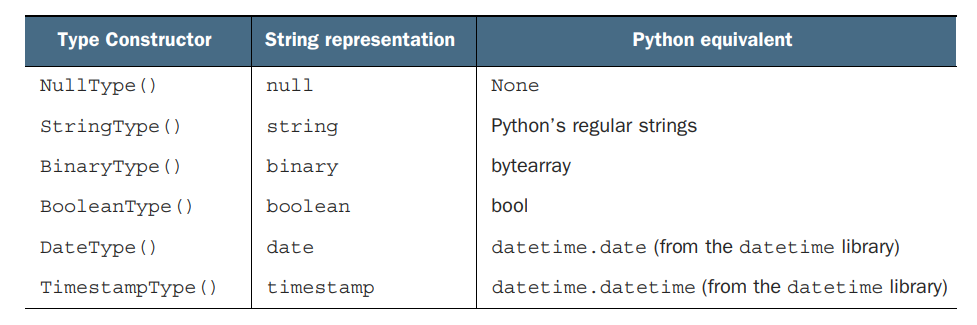
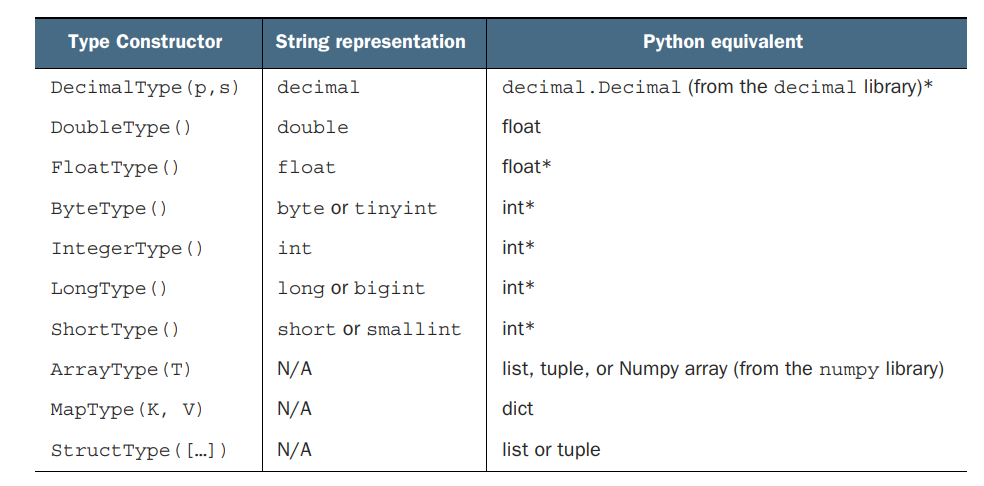

создаем udf и применяем

In [143]:
SparkFrac = t.ArrayType(t.LongType()) # ArrayType соответствует tuple
reduce_fraction = f.udf(py_reduce_fraction, SparkFrac)

frac_df = frac_df.withColumn(
    "reduced_fraction",
    reduce_fraction(f.col("fraction"))
)
frac_df.show()

+--------+----------------+
|fraction|reduced_fraction|
+--------+----------------+
|  [1, 1]|          [1, 1]|
|  [1, 2]|          [1, 2]|
|  [1, 3]|          [1, 3]|
|  [1, 4]|          [1, 4]|
|  [1, 5]|          [1, 5]|
|  [1, 6]|          [1, 6]|
|  [1, 7]|          [1, 7]|
|  [1, 8]|          [1, 8]|
|  [1, 9]|          [1, 9]|
| [1, 10]|         [1, 10]|
| [1, 11]|         [1, 11]|
| [1, 12]|         [1, 12]|
| [1, 13]|         [1, 13]|
| [1, 14]|         [1, 14]|
| [1, 15]|         [1, 15]|
| [1, 16]|         [1, 16]|
| [1, 17]|         [1, 17]|
| [1, 18]|         [1, 18]|
| [1, 19]|         [1, 19]|
| [1, 20]|         [1, 20]|
+--------+----------------+
only showing top 20 rows



удобно создавать udf с помощью декоратора  
декоратор - ф-ия, применяемая к другим ф-иям через знак @

In [146]:
@f.udf(t.DoubleType())
def py_fraction_to_float(frac: Frac) -> Optional[float]:
    """Transforms a fraction represented as a 2-tuple of integers into a float."""
    num, denom = frac
    if denom:
        return num / denom
    return None

frac_df = frac_df.withColumn(
    'frac_float', py_fraction_to_float(f.col('reduced_fraction'))
)

frac_df.show()

+--------+----------------+--------------------+
|fraction|reduced_fraction|          frac_float|
+--------+----------------+--------------------+
|  [1, 1]|          [1, 1]|                 1.0|
|  [1, 2]|          [1, 2]|                 0.5|
|  [1, 3]|          [1, 3]|  0.3333333333333333|
|  [1, 4]|          [1, 4]|                0.25|
|  [1, 5]|          [1, 5]|                 0.2|
|  [1, 6]|          [1, 6]| 0.16666666666666666|
|  [1, 7]|          [1, 7]| 0.14285714285714285|
|  [1, 8]|          [1, 8]|               0.125|
|  [1, 9]|          [1, 9]|  0.1111111111111111|
| [1, 10]|         [1, 10]|                 0.1|
| [1, 11]|         [1, 11]| 0.09090909090909091|
| [1, 12]|         [1, 12]| 0.08333333333333333|
| [1, 13]|         [1, 13]| 0.07692307692307693|
| [1, 14]|         [1, 14]| 0.07142857142857142|
| [1, 15]|         [1, 15]| 0.06666666666666667|
| [1, 16]|         [1, 16]|              0.0625|
| [1, 17]|         [1, 17]|0.058823529411764705|
| [1, 18]|         [